# Реализация Tanh и аугментаций
### Исследование их влияния на точность классификации цифр

In [316]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork 
from IPython.display import clear_output
%matplotlib inline

In [317]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [318]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

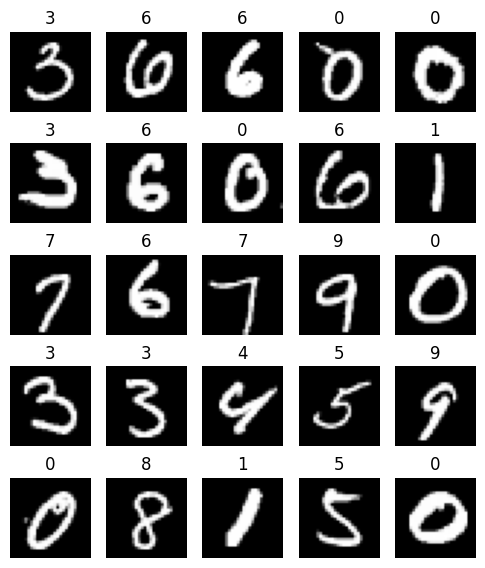

In [319]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [320]:
def train(network, epochs, learning_rate, train_loader, test_loader, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate) 
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [321]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.312/0.306	Accuracy: 0.918/0.918

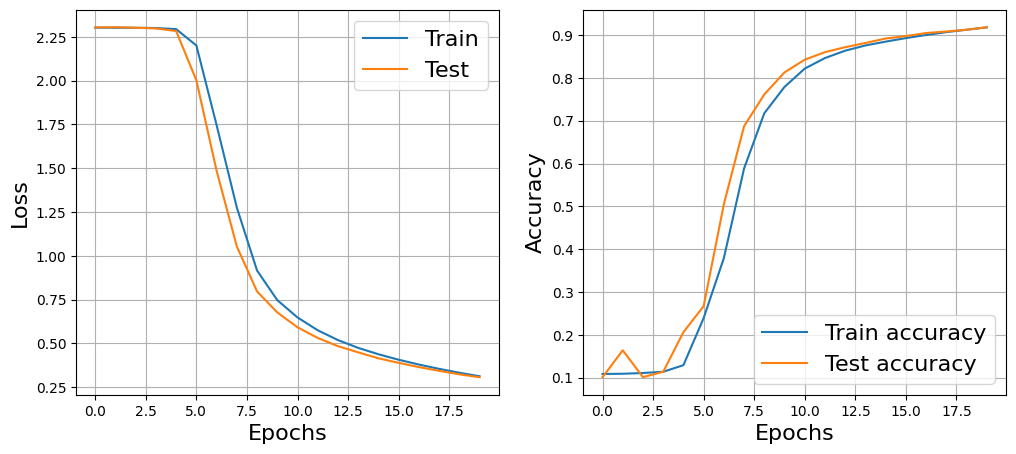

In [322]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01, train_loader, test_loader)

### Часть 2: Нелинейности

Обучим нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [323]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [324]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.036/0.090	Accuracy: 0.990/0.974

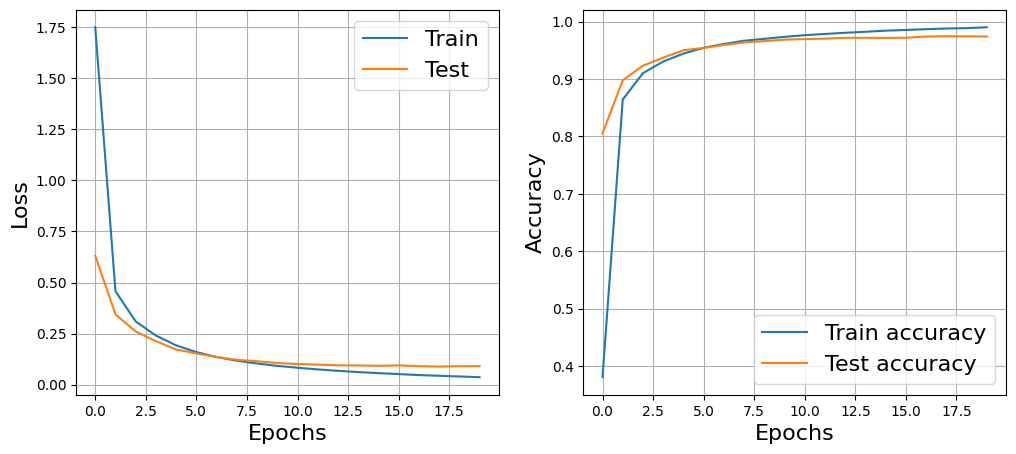

In [325]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, train_loader, test_loader, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.046/0.085	Accuracy: 0.987/0.974

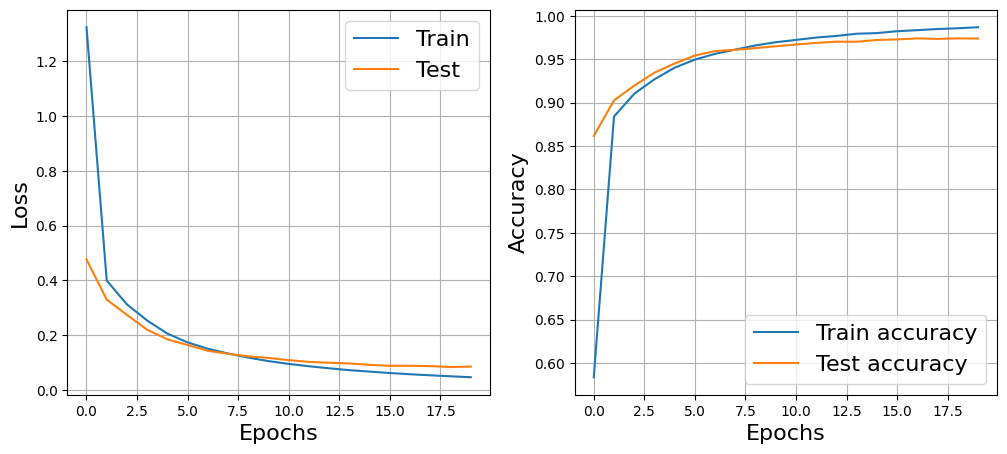

In [326]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, train_loader, test_loader, plot=True, verbose=True)

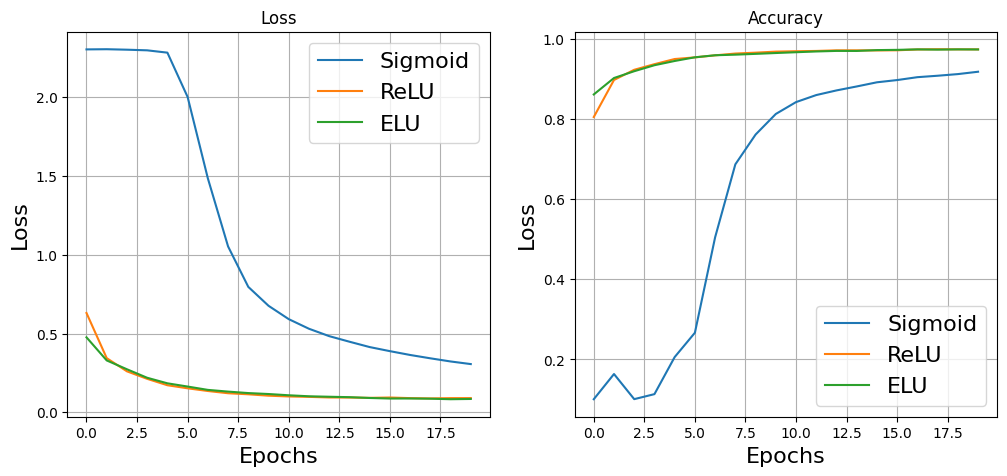

In [327]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### 1.1 Реализация Tanh

Реализуем функцию гиперболического тангенса

In [328]:
class Tanh:
    '''
    Tanh(x) = 2/(1+e**(-2*x))-1
    '''
    @staticmethod
    def get_Tanh(X):
        return (2/(1+np.exp(-2*X))-1)
    

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return self.get_Tanh(X)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = 1-self.get_Tanh(X)**2
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.031/0.079	Accuracy: 0.993/0.976

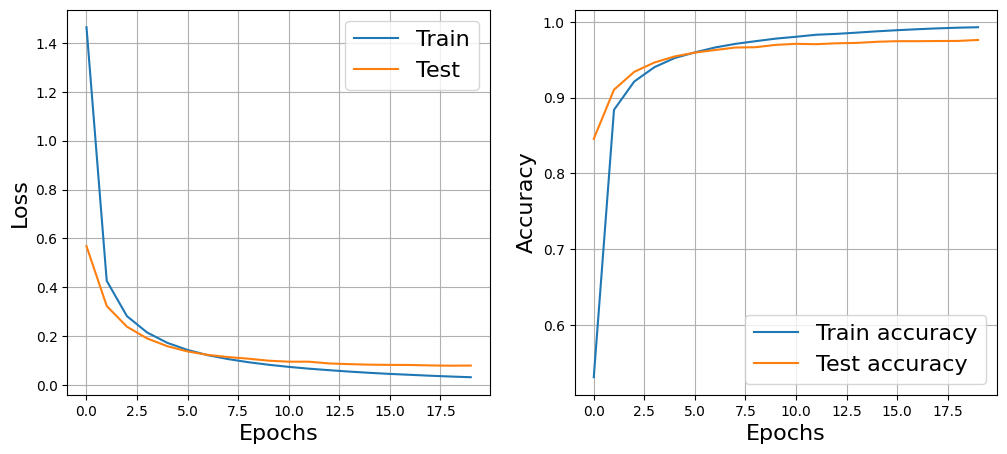

In [329]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])

tr_tanh, ts_tanh, tr_ac_tanh, ts_ac_tanh = train(network, 20, 0.01, train_loader, test_loader, plot=True, verbose=True)

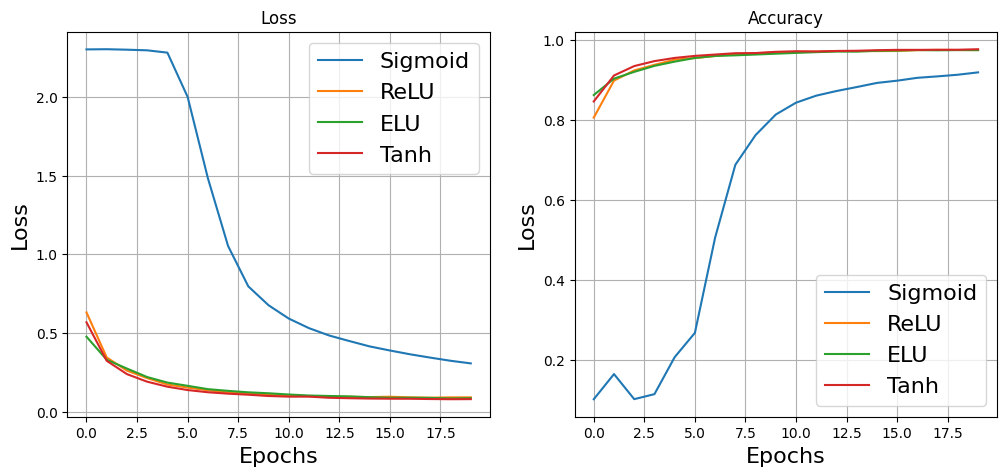

In [330]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_tanh, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_tanh, label='Tanh')

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Tanh справился хорошо - наравне с Relu и ELU

### Часть 3: Анализ ошибок

Посмотрим ошибки, которые совершила нейросеть с функцией активации tanh

In [331]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

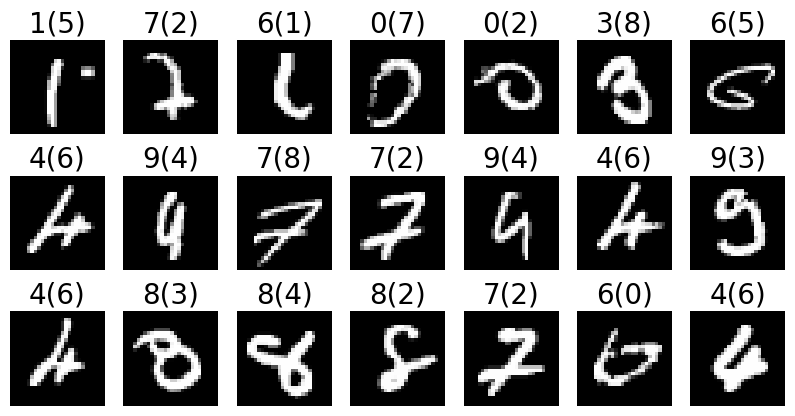

In [332]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### 1.2 Аугментации
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [561]:
import skimage
import random
from PIL import Image
import cv2
from matplotlib import pyplot as plt

Для начала создадим функции для открытия картинок по адресу и просмотру их.

In [562]:

def open_image(path):
    bgr_img = cv2.imread('cake.jpg')
    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    return img


def show_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [563]:

class Augmentations:
    
    #вращение картинки
    @staticmethod
    def rotate(img):
        if isinstance(img, Image.Image):
            img = np.array(img)
        return skimage.transform.rotate(img,random.randint(-15,15))

    #добавление шумов в картинку
    @staticmethod
    def make_noise(img):
        if isinstance(img, Image.Image):
            img = np.array(img)
        return skimage.util.random_noise(img, mode='gaussian',mean = 0, var = 0.1,clip=True)


    #сдвиг картинки
    @staticmethod
    def shift(img):
        if isinstance(img, Image.Image):
            img = np.array(img)
        if len(img.shape)==3:

            height, width,_ = img.shape
        elif (len(img.shape)==2):
            height, width = img.shape

        shift_matrix = (random.randint(-int(height/5),int(height/5)),random.randint(-int(width/5),int(width/5)))
        transformation = skimage.transform.AffineTransform(translation=shift_matrix)
        
        return skimage.transform.warp(img,transformation,mode='wrap', preserve_range= True)/255
    
    
    


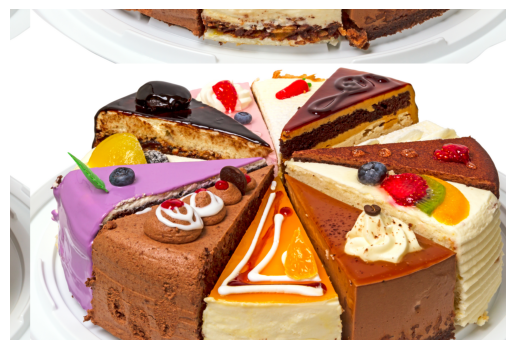

In [581]:
img = open_image('cake.jpg')

shifted_image = Augmentations.shift(img)

show_image(shifted_image)


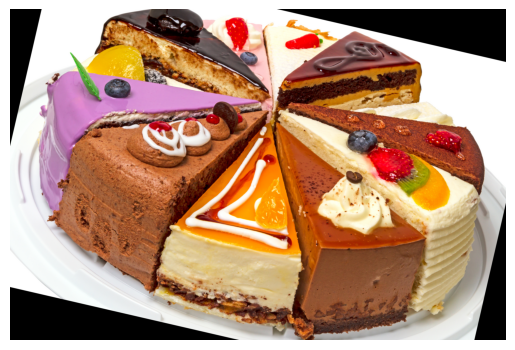

In [565]:

rotated_image = Augmentations.rotate(img)
show_image(rotated_image)


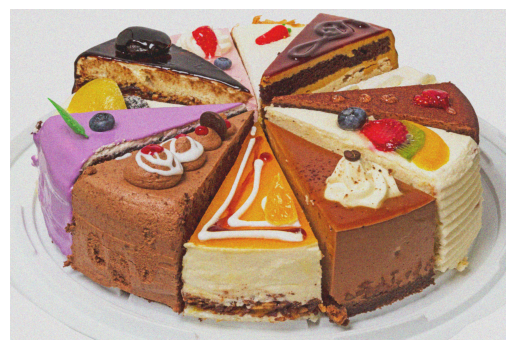

In [566]:
image_with_noise = Augmentations.make_noise(img)
show_image(image_with_noise)



Теперь обучим нейросеть с аугментациями вместе и по отдельности. В качестве нелинейности возьмем гиперболический тангенс, так как он показал хорошее качество при прошлом обучении

Аугментация - сдвиг

In [567]:
transform_shift = transforms.Compose([

                       transforms.Lambda(lambda img: Augmentations.shift(img)),
                    
                     transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_shift = MNIST('.', train=True, download=True, transform=transform_shift)
test_dataset_shift = MNIST('.', train=False, transform=transform_shift)

train_loader_shift = DataLoader(train_dataset_shift, batch_size=32, shuffle=True)
test_loader_shift = DataLoader(test_dataset_shift, batch_size=32, shuffle=False)

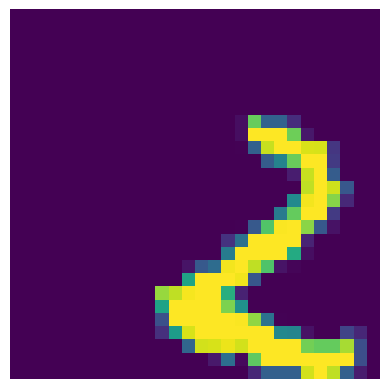

tensor([2, 7, 2, 0, 7, 8, 8, 2, 3, 8, 8, 7, 3, 4, 6, 4, 0, 7, 4, 7, 6, 6, 7, 3,
        4, 8, 6, 7, 8, 9, 7, 0])


In [568]:
for imgs, l in train_loader_shift:
    show_image(imgs[0].permute(1,2,0))
    print(l)
    break

Epoch 19... (Train/Test) NLL: 0.184/0.176	Accuracy: 0.942/0.943

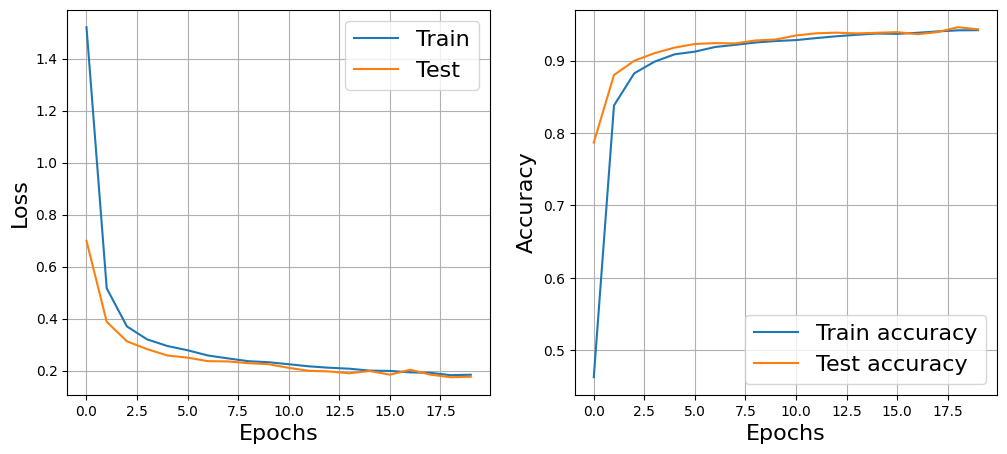

In [569]:
network_shift =  NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])


tr_shift, ts_shift, tr_ac_shift, ts_ac_shift = train(network_shift, 20, 0.05, train_loader_shift, test_loader_shift, plot=True, verbose=True)

Аугментация - повороты

In [570]:
transform_rotate = transforms.Compose([

                       transforms.Lambda(lambda img: Augmentations.rotate(img)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_rotate = MNIST('.', train=True, download=True, transform=transform_rotate)
test_dataset_rotate = MNIST('.', train=False, transform=transform_rotate)

train_loader_rotate = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_rotate = DataLoader(test_dataset, batch_size=32, shuffle=False)

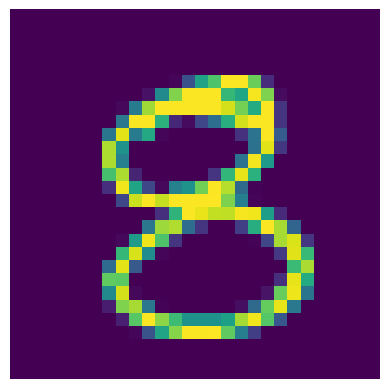

tensor([8, 3, 3, 0, 9, 5, 9, 4, 2, 6, 8, 2, 9, 1, 3, 0, 2, 3, 8, 8, 1, 8, 3, 6,
        3, 9, 9, 9, 7, 5, 4, 4])


In [571]:
for imgs, l in train_loader_rotate:
    show_image(imgs[0].permute(1,2,0))
    print(l)
    break

Epoch 19... (Train/Test) NLL: 0.002/0.081	Accuracy: 1.000/0.980

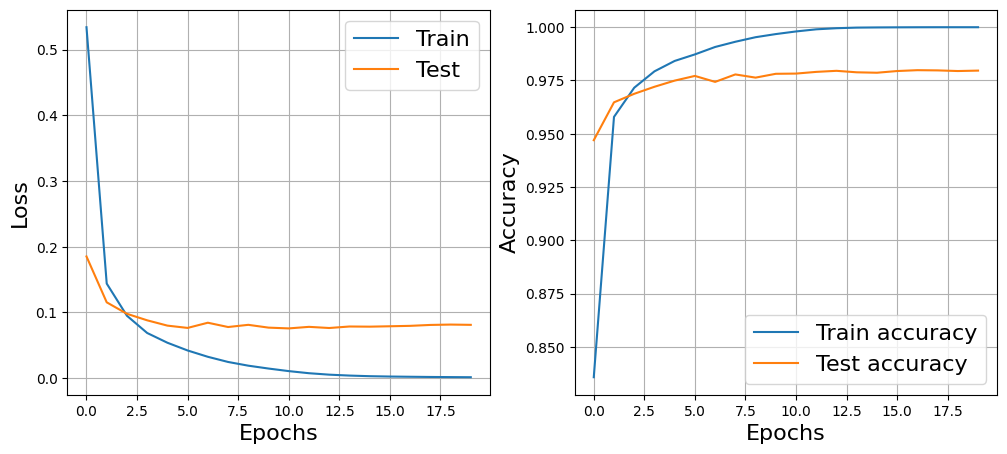

In [572]:
network_rotate =  NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])


tr_rotate, ts_rotate, tr_ac_rotate, ts_ac_rotate = train(network_rotate, 20, 0.05, train_loader_rotate, test_loader_rotate, plot=True, verbose=True)

Аугментация - шум 

In [573]:
transform_noise = transforms.Compose([
                        # transforms.Lambda(lambda img: Augmentations.rotate(img)),
                     #   transforms.Lambda(lambda img: Augmentations.shift(img)),
                       transforms.Lambda(lambda img: Augmentations.make_noise(img)),
                 
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_noise = MNIST('.', train=True, download=True, transform=transform_noise)
test_dataset_noise = MNIST('.', train=False, transform=transform_noise)

train_loader_noise = DataLoader(train_dataset_noise, batch_size=32, shuffle=True)
test_loader_noise = DataLoader(test_dataset_noise, batch_size=32, shuffle=False)

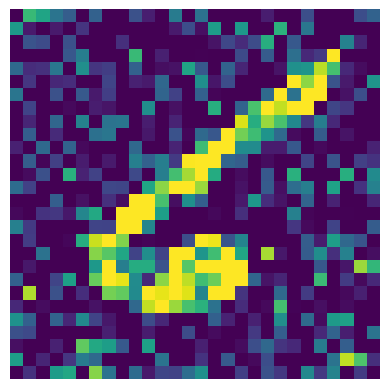

tensor([6, 9, 8, 6, 3, 4, 7, 7, 7, 0, 1, 2, 8, 7, 9, 0, 4, 6, 7, 8, 8, 0, 4, 1,
        0, 1, 8, 4, 1, 2, 1, 0])


In [574]:
for imgs, l in train_loader_noise:
    show_image(imgs[0].permute(1,2,0))
    print(l)
    break

Epoch 19... (Train/Test) NLL: 0.066/0.108	Accuracy: 0.978/0.968

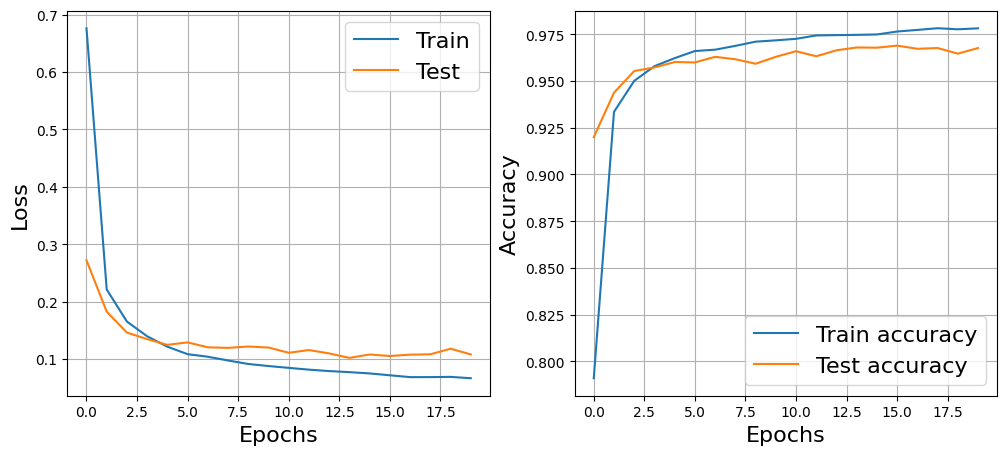

In [575]:
network_noise =  NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])


tr_noise, ts_noise, tr_ac_noise, ts_ac_noise = train(network_noise, 20, 0.05, train_loader_noise, test_loader_noise, plot=True, verbose=True)

Все 3 аугментации - поворот, сдвиг, шумы

In [576]:
transform_augmentations = transforms.Compose([
                        transforms.Lambda(lambda img: Augmentations.shift(img)),
                        transforms.Lambda(lambda img: Augmentations.rotate(img)),
                     
                       transforms.Lambda(lambda img: Augmentations.make_noise(img)),
                 
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_augmentations = MNIST('.', train=True, download=True, transform=transform_augmentations)
test_dataset_augmentations = MNIST('.', train=False, transform=transform_augmentations)

train_loader_augmentations = DataLoader(train_dataset_augmentations, batch_size=32, shuffle=True)
test_loader_augmentations = DataLoader(test_dataset_augmentations, batch_size=32, shuffle=False)

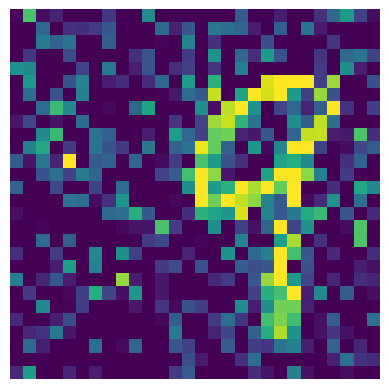

tensor([9, 3, 3, 2, 0, 6, 8, 0, 5, 5, 9, 4, 1, 3, 5, 5, 0, 8, 4, 4, 1, 2, 0, 1,
        5, 8, 0, 7, 5, 6, 4, 0])


In [577]:
for imgs, l in train_loader_augmentations:
    show_image(imgs[0].permute(1,2,0))
    print(l)
    break

Epoch 19... (Train/Test) NLL: 0.394/0.383	Accuracy: 0.874/0.877

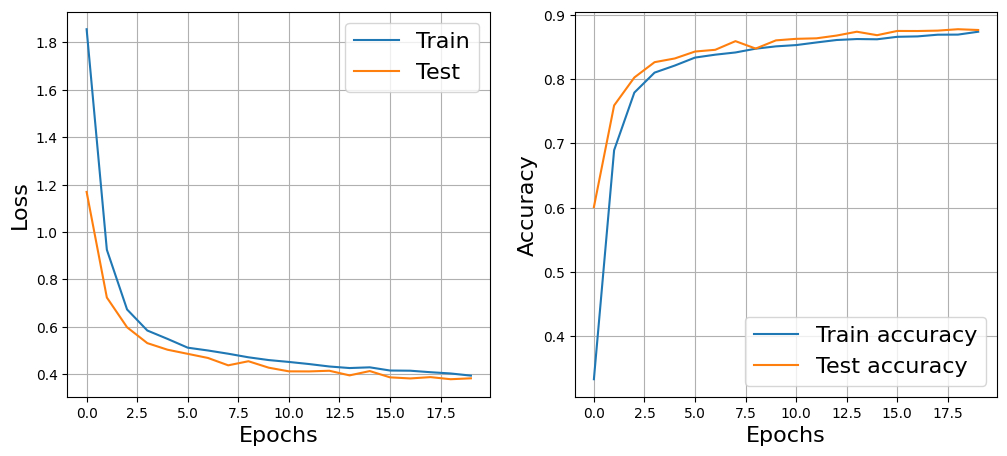

In [578]:
network_augmentations =  NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])


tr_augmentations, ts_augmentations, tr_ac_augmentations, ts_ac_augmentations = train(network_augmentations, 20, 0.05, train_loader_augmentations, test_loader_augmentations, plot=True, verbose=True)

Посмотрим разницу в loss и точности на графике

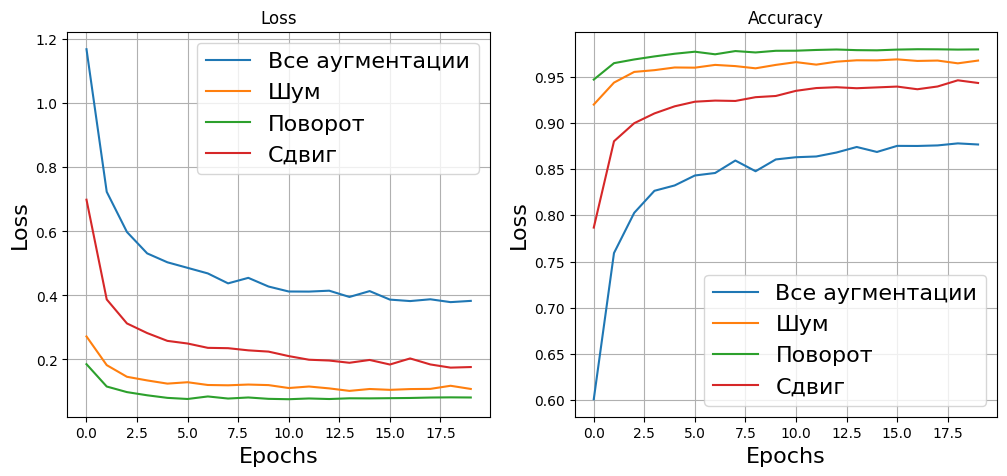

In [579]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_augmentations, label='Все аугментации')
plt.plot(ts_noise, label='Шум')
plt.plot(ts_rotate, label='Поворот')
plt.plot(ts_shift, label='Сдвиг')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_augmentations, label='Все аугментации')
plt.plot(ts_ac_noise, label='Шум')
plt.plot(ts_ac_rotate, label='Поворот')
plt.plot(ts_ac_shift, label='Сдвиг')

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Сравнение модели с Tanh без и с аугментацией поворот.

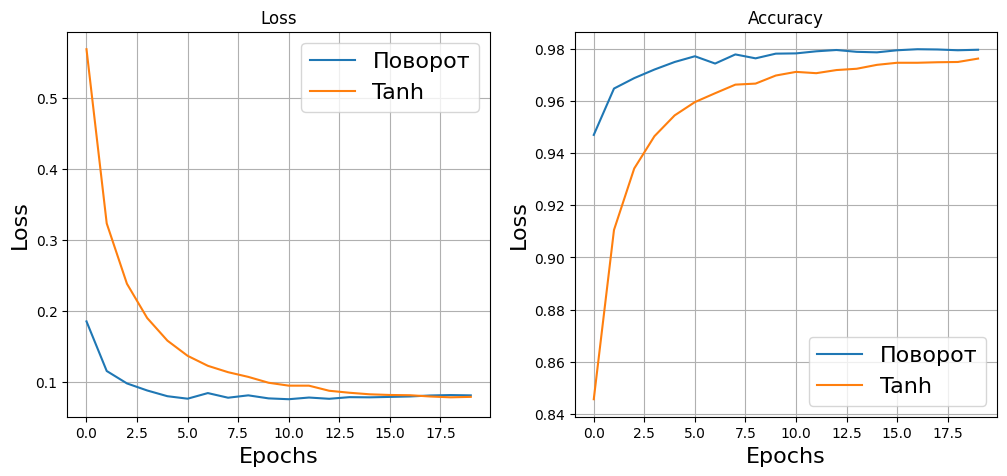

In [580]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')

plt.plot(ts_rotate, label='Поворот')
plt.plot(ts_tanh, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_rotate, label='Поворот')
plt.plot(ts_ac_tanh, label='Tanh')

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Как мы видим, аугментации положительно влияют на качество предсказаний.

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Для проверки влияния аугментаций на итоговое качество предсказаний для каждого из 4 случаев: шум, сдвиг, поворот, все вместе, были взяты одинаковые гиперпараметры - кол-во нейронов, learning rate и количество эпох. По графику нетрудно заметить, что за 20 эпох лучшей точности мы смогли добиться для аугментации поворот. Простая аугментация, которая поворачивает картинку цифры на +-15 градусов, но в то же время самая действенная. После нее идет шум, который показал качество чуть хуже. Сдвиг и слияние всех аугментаций не сильно понравилось модели, что может быть понятно - сдвиг может срезать цифру, что сказывается на результах.


Таким образом - аугментация поворот показала себя наилучим образом, превзойдя все остальные обученные нейронки по точности.